Выполнил: Тазиев Тимур

#### Дан файл эксель с заказами клиентов (у одного клиента может быть несколько заказов) 

- user_id – идентификатор пользователя
- checks - сумма покупки

In [1]:
# загрузка данных
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

# настройки для вывода графиков
sns.set(rc={'figure.figsize': (10,4),'figure.dpi': (80)},style='darkgrid')

# считываем данные
df = pd.read_excel('dz4.xlsx')
df.rename(columns={'cheks': 'check'},inplace=True)
df['check'] = df['check'].round(2)


#### ***A/A тестирование представляет собой метод статистического контроля, в рамках которого:***
- **Идентичные группы:** Две одинаковые или практически одинаковые группы.
- **Одни и те же условия:** Группы подвергаются одним и тем же условиям эксперимента.
- **Стабильность перед основным тестом:** Проверка системы или инструментов на стабильность перед основным тестированием.
- **Цель — исключить систематические различия:** Убеждение в отсутствии значимых различий между группами до начала основного эксперимента.

### `графики распределения`

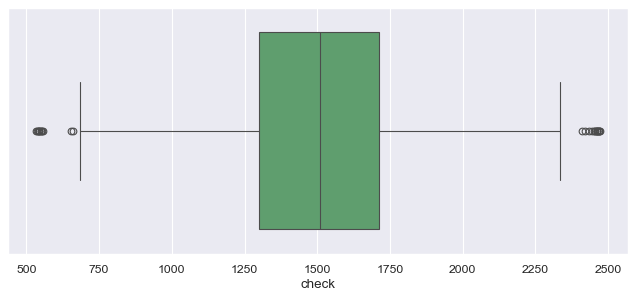

In [2]:
sns.boxplot(data=df,x='check',color='g');

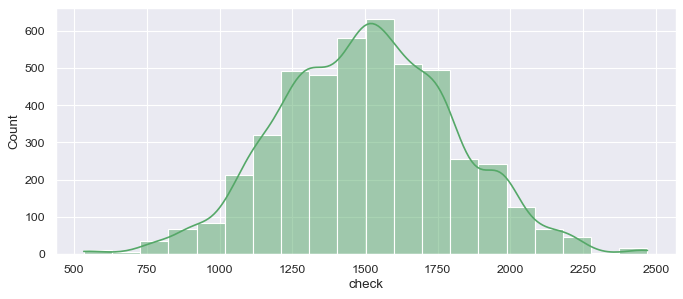

In [3]:
sns.histplot(data=df.check, kde=True, bins=20, color='g');

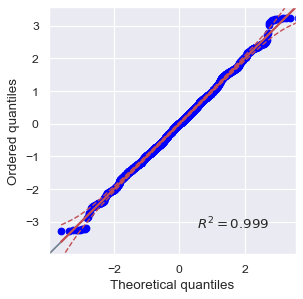

In [4]:
pg.qqplot(df.check);

### 1. Проверить, что распределение p-value на А/А-тестах для среднего чека (глобальное среднее) в по-юзерном тесте далеко не идеально в t-критерии, сделать вывод о применимости t-тест.

**Прежде чем выполнять t-test мы должны убедиться что выполнены условия**:
- Выборки должны быть случайными          `(да)`
- Выборки не зависят друг от друга        `(да)`
- Равенство дисперсий(гомоскедантичность) `(да)`
- Распределение нормальное                `(да)`

`выборки разделены случайным образом`

In [49]:
# средняя цена чека в по-юзерном тесте
data = df.groupby('user_id')['check'].mean().reset_index()

# Создадим две идентичные группы, используя np.random.choice. запишем все в колонку 'group'
group_1 = data.sample(frac=0.5)
group_2 = data.drop(group_1.index)

group_1['group'] = 1
group_2['group'] = 2

# Объединение обеих групп в один DataFrame
data['group'] = pd.concat([group_1, group_2]).group

`Выборки не зависят друг от друга` 
- так как чеки сначала были усреднены для каждого пользователя, затем разделены на группы
- если было бы сразу разделение, то чеки одного и того же user_id могли быть в двух группах сразу, тогда была бы связь

`гомоскедантичность`

In [50]:
pg.homoscedasticity(data= data, dv = 'check', group='group', method='levene')

,W,pval,equal_var
levene,0.343585,0.557899,True


`нормальность распределения`

In [51]:
pg.normality(data=data,dv='check', group='group',method='normaltest').reset_index()

,group,W,pval,normal
0,1,0.813230,0.665901,True
1,2,0.066665,0.967217,True


#### создание списка p-val и проверка распределения

In [67]:
# отказался от group. так как надо обновлять средние значения для построения распределения p-val
data.drop(['user_id','group'],axis=1,inplace=True)

In [55]:
# создание списка p-val
from scipy.stats import ttest_ind, norm
pvals = []

for _ in range(10000):
    a = data.sample(frac=0.5)
    b = data.drop(a.index)
    t_stat, p_value = ttest_ind(a, b)
    pvals.append(p_value)

In [82]:
b.std()

check    291.159844
dtype: float64

,W,pval,normal
0,14818.650977,0.0,False


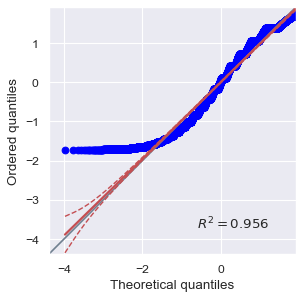

In [56]:
# проверка на нормальность
pg.qqplot(pvals);
pg.normality(data=np.concatenate(pvals),method='normaltest')

### 2. Проверить через распределение p-value на А/А-тестах, работает ли дельта-метод для глобального среднего.

In [21]:
p_vals = []

for _ in range(10000):
    a = data.sample(frac=0.5)
    b = data.drop(a.index)

    # Применение дельта-метода для расчета p-значения
    pooled_standard_error = np.sqrt(a.var() / len(a) + b.var() / len(b))
    z_value = (a.mean() - b.mean()) / pooled_standard_error
    p_value = 2 * (1 - norm.cdf(abs(z_value)))

    p_vals.append(p_value)

# Вывод среднего значения p-value
print(f'Среднее p-values: {np.mean(p_vals).round(3)}')


Среднее p-values: 0.503


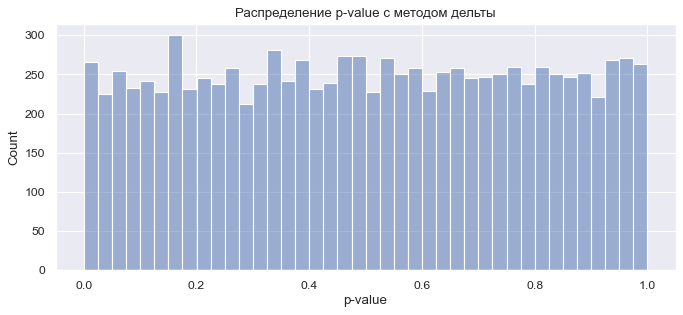

In [22]:
sns.histplot(np.array(p_vals), bins=40, legend=False)
plt.title('Распределение p-value с методом дельты')
plt.xlabel('p-value');

In [23]:
p_vals_np = np.array(p_vals)
percent_p_05 = np.mean(p_vals_np > 0.05) * 100
print(f'Процент значений p-value больше 0.05: {percent_p_05:.2f}%')

Процент значений p-value больше 0.05: 95.09%


**Вывод:**  `дельта-метод для глобального среднего в данном случае работает достаточно хорошо. Распределение p-value показывает себя согласно ожиданиям`

### 3. Проверить аналогично прошлым пунктам применимость t-теста для нормализованного (двойного) среднего.

Как я понял: 
- двойная средняя - `это процесс центрирования или нормализации относительно двух различных средних значений.`

In [13]:
p_vals = []

for _ in range(2000):
    a = data.sample(frac=0.5)
    b = data.drop(a.index)

    norm_a = (a - a.min()) / (a.max() - a.min())
    norm_b = (b - b.min()) / (b.max() - b.min())
        
    # Применение t-теста к нормализованным данным без добавления шума
    _, p_value = ttest_ind(norm_a, norm_b)
    p_vals.append(p_value)

In [14]:
p_vals_np = np.array(p_vals)
percent_p_05 = np.mean(p_vals_np > 0.05) * 100
print(f'Процент значений p-value больше 0.05: {percent_p_05:.2f}%')

Процент значений p-value больше 0.05: 15.05%


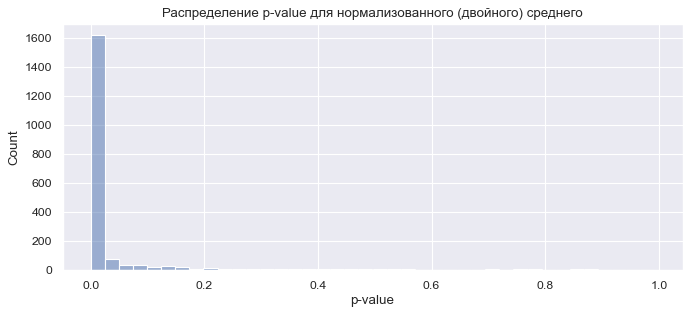

In [15]:
# Построение гистограммы распределения p-value
sns.histplot(np.array(p_vals), bins=40, legend=False)
plt.title('Распределение p-value для нормализованного (двойного) среднего')
plt.xlabel('p-value');

**Вывод:** `Применение t-теста на нормализованных данных для двойного среднего показывает, что более 84% тестов обнаруживают статистически значимые различий между выборками при уровне значимости 0.05. Что очень странно, дельта метод говорит что их нет, а двойного среднее говорит что они есть. Хотя все условия для применения t-теста были соблюдены.`
- Остается 1 вопрос: Правильно ли я применил метод двойного среднего? Я не нашел в интернете понятие (двойное среднее)

`Другой способ нормализации.`

In [93]:
p_vals = []

for _ in range(1000):
    a = data.sample(frac=0.5)
    b = data.drop(a.index)

    # Нормализация данных обеих групп
    norm_a = (a - a.mean()) / a.std()
    norm_b = (b - b.mean()) / b.std()
    
    # Применение t-теста к нормализованным данным без добавления шума
    _, p_value = ttest_ind(norm_a, norm_b)
    p_vals.append(p_value)

# Вывод среднего значения p-value
p_vals_np = np.array(p_vals)
percent_p_05 = np.mean(p_vals_np > 0.05) * 100
print(f'Процент значений p-value больше 0.05: {percent_p_05:.2f}%')


Процент значений p-value больше 0.05: 100.00%


**Вывод:** `Использование другого способа: 100% тестов показывают, что различий между группами нет.`

### 4. Сделать симуляции А/А-тестов таким образом – сгенерить эффект для таргетной группы так, чтобы среднее у него было 0, а дисперсия какая-то ненулевая. Проверить, что нормализованное среднее все еще стабильно в t-тесте.

In [84]:
# Создаем копию DataFrame
data_with_effect = data.copy()

p_values = []
for _ in range(1000):
    # Генерируем значения с добавленным эффектом
    data_with_effect['check_with_effect'] = data_with_effect['check'] + np.random.normal(loc=0, scale=15, size=len(data_with_effect))

    # Разделяем на две группы
    group_1 = data_with_effect.sample(frac=0.5)['check_with_effect']
    group_2 = data_with_effect.drop(group_1.index)['check_with_effect']

    _, p_value = ttest_ind(group_1, group_2)
    p_values.append(p_value)

print("p-val mean:", np.mean(p_values).round(3))

p-val mean: 0.483


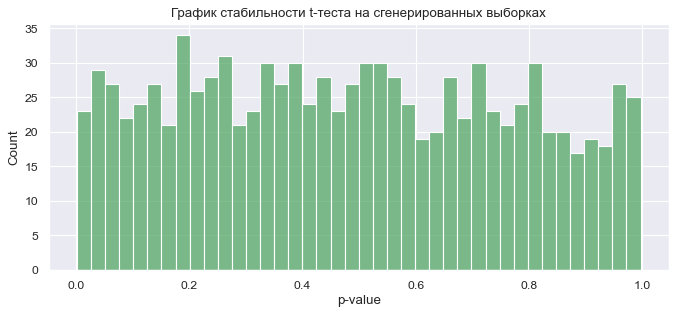

In [85]:
# Построение гистограммы распределения p-value
sns.histplot(np.array(p_values), bins=40, color='g')
plt.title('График стабильности t-теста на сгенерированных выборках')
plt.xlabel('p-value');

**Вывод:** `Статистическая стабильность сохраняется в условиях А/А-тестирования.`


### 5. Аналогично предыдущему пункту сгенерить эффект для таргетной группы так, чтобы среднее у него было 0 и не-нулевая дисперсия, но при этом средний эффект на пользователя был  скоррелирован с кол-вом заказов. Проверить, работает ли t-тест для нормализованного среднего

In [18]:
# Генерируем данные для количества заказов
order_count = np.random.normal(loc= 10, scale=2 , size=1000)

# Создаем эффект, коррелирующий с количеством заказов
effect = 0.5 * order_count + np.random.normal(loc= 0, scale=1, size=1000)

In [19]:
# Нормализация данных
order_count_normalized = (order_count - order_count.mean()) / order_count.std()
effect_normalized = (effect - effect.mean()) / effect.std()

t_statistic_norm, p_value_norm = ttest_ind(order_count_normalized, effect_normalized)

# Вывод результатов
print("T-статистика для нормализованных данных:", t_statistic_norm)
print("p-значение для нормализованных данных:", p_value_norm)

T-статистика для нормализованных данных: -1.985034060558899e-15
p-значение для нормализованных данных: 0.9999999999999984


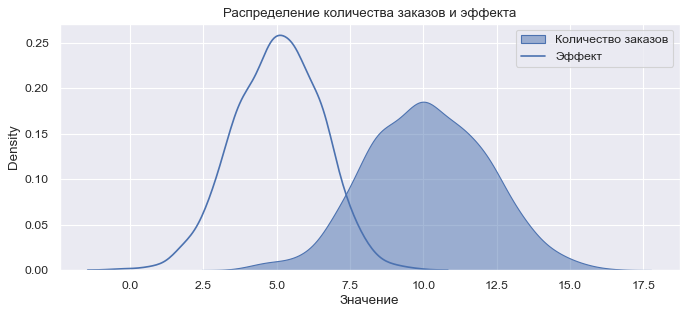

In [20]:
sns.kdeplot(order_count, label='Количество заказов',fill=True, alpha=.5)
sns.kdeplot(effect, label='Эффект')
plt.legend()
plt.title('Распределение количества заказов и эффекта')
plt.xlabel('Значение');

**Вывод:** `результаты t-теста указывают на то, что нет статистически значимых различий между нормализованными средними значениями 'количества заказов' и 'эффекта'.`